In [1]:
#import and read file
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

file_path_train = '/content/drive/MyDrive/LSTM-Multivariate_pollution.csv'
df_train = pd.read_csv(file_path_train)
file_path_test = '/content/drive/MyDrive/pollution_test_data1.csv'
df_test = pd.read_csv(file_path_test)

Mounted at /content/drive


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error as mse

df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

#mapping data to numbers, in order to train
mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}

df_train_scaled['wnd_dir'] = df_train_scaled['wnd_dir'].map(mapping)
df_test_scaled['wnd_dir'] = df_test_scaled['wnd_dir'].map(mapping)
df_train_scaled['date'] = pd.to_datetime(df_train_scaled['date'])
df_train_scaled.set_index('date', inplace=True)
df_train_scaled.head()

#normalization, avoid certain large-value features from dominating model training
scaler = MinMaxScaler()
columns = (['pollution', 'dew', 'temp', 'press', "wnd_dir", 'wnd_spd', 'snow', 'rain'])
df_test_scaled = df_test_scaled[columns]
df_train_scaled[columns] = scaler.fit_transform(df_train_scaled[columns])
df_test_scaled[columns] = scaler.transform(df_test_scaled[columns])

In [3]:
import numpy as np

df_train_scaled = np.array(df_train_scaled)
df_test_scaled = np.array(df_test_scaled)

#constructing samples, we use data of past few days to predict the pollution of the next day
x = []
y = []
n_future = 1
n_past = 12
for i in range(n_past, len(df_train_scaled) - n_future+1):
    x.append(df_train_scaled[i - n_past:i, 1:df_train_scaled.shape[1]])
    y.append(df_train_scaled[i + n_future - 1:i + n_future, 0])
x_train, y_train = np.array(x), np.array(y)

x = []
y = []
for i in range(n_past, len(df_test_scaled) - n_future+1):
    x.append(df_test_scaled[i - n_past:i, 1:df_test_scaled.shape[1]])
    y.append(df_test_scaled[i + n_future - 1:i + n_future, 0])
x_test, y_test = np.array(x), np.array(y)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import Huber

#build LSTM model
model = Sequential()

#build 3 layers of LSTM, and add dropout to prevent overfitting, and add a fully connected layer make an output
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(y_train.shape[1]))

#use huber loss function, adam optimizer, and rmse to evaluate train result
model.compile(loss=Huber(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

#use early stopping to avoid overfitting and accelerate traning, set patience to 10
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

#epochs, batch size, validation split, validation freq can be adjusted. validation freq is used to accelerate
history = model.fit(x_train, y_train, epochs=150, batch_size=64, validation_split=0.1, callbacks=[early_stopping, checkpoint], shuffle=False, validation_freq=5)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0040 - root_mean_squared_error: 0.0892
Epoch 2/150


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,root_mean_squared_error
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


616/616 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0041 - root_mean_squared_error: 0.0899
Epoch 3/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0040 - root_mean_squared_error: 0.0889
Epoch 4/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0038 - root_mean_squared_error: 0.0872
Epoch 5/150
613/616 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - root_mean_squared_error: 0.0866

616/616 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0038 - root_mean_squared_error: 0.0865 - val_loss: 0.0056 - val_root_mean_squared_error: 0.1061
Epoch 6/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0037 - root_mean_squared_error: 0.0857
Epoch 7/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0035 - root_mean_squared_error: 0.0839
Epoch 8/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0035 - root_mean_squared_error: 0.0836
Epoch 9/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0034 - root_mean_squared_error: 0.0827
Epoch 10/150
615/616 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - root_mean_squared_error: 0.0815

616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0033 - root_mean_squared_error: 0.0815 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0913
Epoch 11/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0032 - root_mean_squared_error: 0.0797
Epoch 12/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0032 - root_mean_squared_error: 0.0795
Epoch 13/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0031 - root_mean_squared_error: 0.0782
Epoch 14/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0030 - root_mean_squared_error: 0.0777
Epoch 15/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - root_mean_squared_error: 0.0769

616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0030 - root_mean_squared_error: 0.0769 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0768
Epoch 16/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0029 - root_mean_squared_error: 0.0765
Epoch 17/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0029 - root_mean_squared_error: 0.0758
Epoch 18/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0028 - root_mean_squared_error: 0.0751
Epoch 19/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0028 - root_mean_squared_error: 0.0752
Epoch 20/150
615/616 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - root_mean_squared_error: 0.0749

616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0028 - root_mean_squared_error: 0.0749 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0715
Epoch 21/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0028 - root_mean_squared_error: 0.0745
Epoch 22/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0028 - root_mean_squared_error: 0.0741
Epoch 23/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0028 - root_mean_squared_error: 0.0742
Epoch 24/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0028 - root_mean_squared_error: 0.0740
Epoch 25/150
614/616 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - root_mean_squared_error: 0.0738

616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0027 - root_mean_squared_error: 0.0738 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0715
Epoch 26/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0027 - root_mean_squared_error: 0.0738
Epoch 27/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0027 - root_mean_squared_error: 0.0736
Epoch 28/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0027 - root_mean_squared_error: 0.0735
Epoch 29/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0027 - root_mean_squared_error: 0.0733
Epoch 30/150
613/616 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - root_mean_squared_error: 0.0732

616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0027 - root_mean_squared_error: 0.0732 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0703
Epoch 31/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0027 - root_mean_squared_error: 0.0731
Epoch 32/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0027 - root_mean_squared_error: 0.0730
Epoch 33/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0027 - root_mean_squared_error: 0.0730
Epoch 34/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0027 - root_mean_squared_error: 0.0730
Epoch 35/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0027 - root_mean_squared_error: 0.0728 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0706
Epoch 36/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0027 - root_mean_squared_error: 0.0729
Epoch 37/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0027 - root_mean_squared_error: 0.0727
Epoch 38/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.002

616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0026 - root_mean_squared_error: 0.0724 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0698
Epoch 41/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0026 - root_mean_squared_error: 0.0724
Epoch 42/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0026 - root_mean_squared_error: 0.0720
Epoch 43/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0026 - root_mean_squared_error: 0.0721
Epoch 44/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0026 - root_mean_squared_error: 0.0721
Epoch 45/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0026 - root_mean_squared_error: 0.0719 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0699
Epoch 46/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0026 - root_mean_squared_error: 0.0720
Epoch 47/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0026 - root_mean_squared_error: 0.0718
Epoch 48/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0026 -

616/616 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0025 - root_mean_squared_error: 0.0708 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0685
Epoch 66/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0025 - root_mean_squared_error: 0.0707
Epoch 67/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0025 - root_mean_squared_error: 0.0706
Epoch 68/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0025 - root_mean_squared_error: 0.0705
Epoch 69/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0025 - root_mean_squared_error: 0.0705
Epoch 70/150
614/616 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - root_mean_squared_error: 0.0704

616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0025 - root_mean_squared_error: 0.0704 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0671
Epoch 71/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0025 - root_mean_squared_error: 0.0702
Epoch 72/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0025 - root_mean_squared_error: 0.0704
Epoch 73/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0025 - root_mean_squared_error: 0.0700
Epoch 74/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0025 - root_mean_squared_error: 0.0699
Epoch 75/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0025 - root_mean_squared_error: 0.0698 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0673
Epoch 76/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0025 - root_mean_squared_error: 0.0698
Epoch 77/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0024 - root_mean_squared_error: 0.0697
Epoch 78/150
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0024 

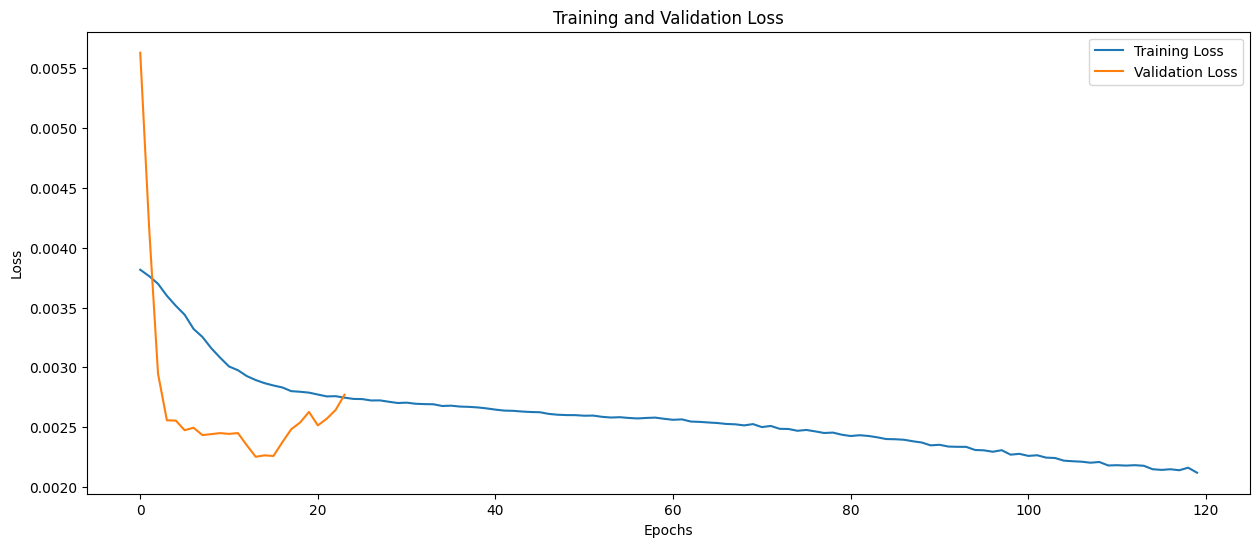

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


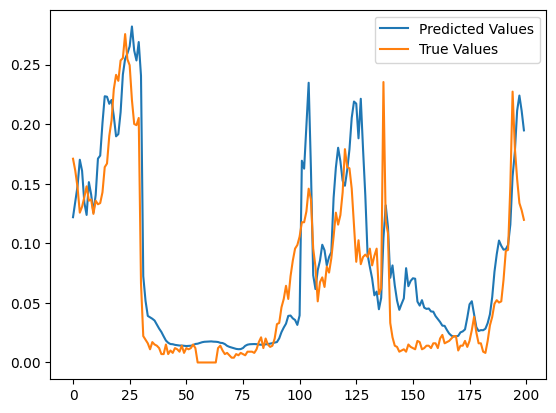

In [14]:
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model

best_model = load_model(
    'best_model.h5',
    custom_objects={
        'RootMeanSquaredError': RootMeanSquaredError()
    }
)

plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_predictions = best_model.predict(x_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,'Actual':y_test.flatten()})
test_results.head()

plt.plot(test_results['Train Predictions'][:200], label='Predicted Values')
plt.plot(test_results['Actual'][:200], label='True Values')
plt.legend()
plt.show()

In [11]:
test_predictions = best_model.predict(x_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,'Actual':y_test.flatten()})
test_results.head()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


,Train Predictions,Actual
0,0.121946,0.171026
1,0.134796,0.160966
2,0.148110,0.146881
3,0.170172,0.125755
4,0.160818,0.130785


In [17]:
from math import sqrt
from sklearn.metrics import r2_score

rmse = sqrt(mse(y_test, test_predictions))
print('Test RMSE: %.5f' % rmse)

r2 = r2_score(y_test, test_predictions)
print('Test r2: %.5f' % r2)

Test RMSE: 0.06669
Test r2: 0.54930
